In [1]:
# magics: ensures that any changes to the modules loaded below will be re-loaded automatically
%load_ext autoreload
%autoreload 2

import os 
import sys
sys.path.append(os.path.abspath(''))
import numpy as np
import plotly.graph_objects as go

In [2]:
from functions import plotgenerator as pg
import utils, model, egm, simulations, estimation 

# Solution to the model

In [3]:
# Setup
par_init_sol = model.gp_model()

### plotting Income shifter

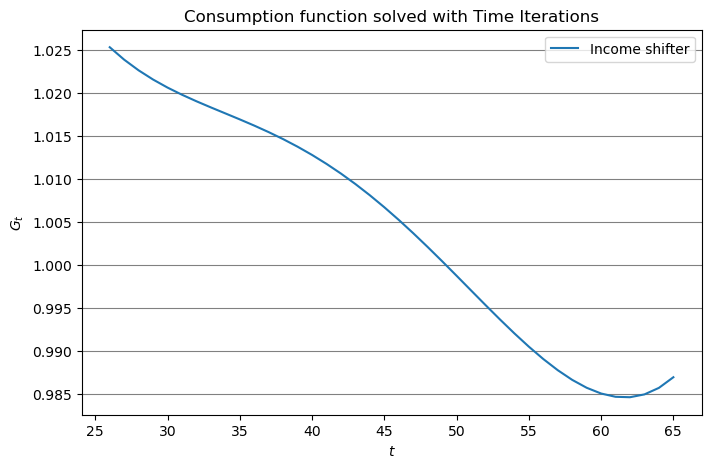

In [4]:
# Print consumption function
fig = pg.PlotFigure(figsize=(8,5),fontname='Arial')
fig.add_plot(range(par_init_sol.par.t0,par_init_sol.par.Tr+1),par_init_sol.par.G, label=f"Income shifter", linestyle='-')
fig.set_ylabel(f"$G_t$")
fig.set_xlabel(f"$t$")
fig.set_title(f'Consumption function solved with Time Iterations')
fig.add_gridlines(axis='y')
fig.add_legend()
fig.show()

### solving the model

In [5]:
# Solve the model
solObj = egm.solver(par_init_sol.par)
solObj.solve(do_print=False)
sol = solObj.sol


### plotting the results

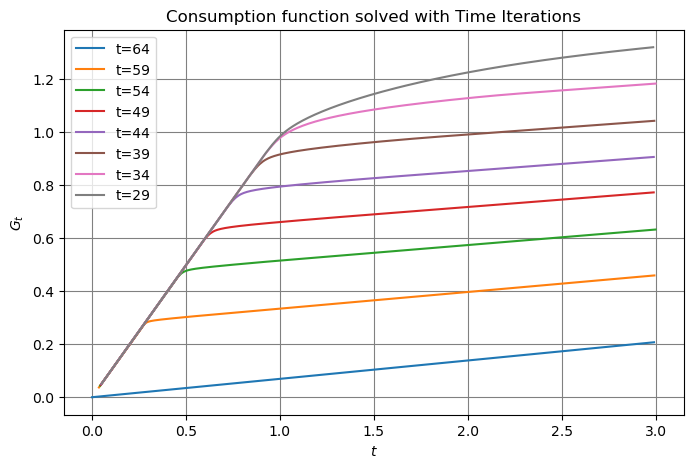

In [6]:
# Print consumption function
fig = pg.PlotFigure(figsize=(8,5),fontname='Arial')
for t in range(par_init_sol.par.Tr_N-1,par_init_sol.par.t0_N,-5):
    criteria = np.where(sol.m[:,t] <= 3, True, False)
    fig.add_plot(sol.m[criteria,t],sol.c[criteria,t], label=f"t={25+t}", linestyle='-')
fig.set_ylabel(f"$G_t$")
fig.set_xlabel(f"$t$")
fig.set_title(f'Consumption function solved with Time Iterations')
fig.add_gridlines(axis='both')
fig.add_legend()
fig.show()

### simulate how results look like

9.82896531, 10.18651767, 10.46990084, 10.72645156, 10.96004293,
11.19377712, 11.41192685, 11.62197534, 11.82168921, 11.99600398,
12.13043367, 12.22161626, 12.25835818, 12.23961723, 12.18041447,
12.08343649, 11.96436432, 11.82546077, 11.67411225, 11.51089696,
11.35159585, 11.1913203 , 11.03049828, 10.87601791, 10.72173028,
10.57055774, 10.41841583, 10.2696319 , 10.12328717,  9.98103472,
9.84161167,  9.70308637,  9.56536886,  9.42827782,  9.29661561,
9.1648085 ,  9.0335425 ,  8.90548768,  8.77691323,  8.65137395

In [7]:
# sim = simulations.sim_setup(par_init_sol.par)
# simulations.draw_random(par_init_sol.par, sim)
# sim = simulations.simulate(sim, par_init_sol.par, sol)
sim = simulations.Simulator(par_init_sol.par, sol).sim

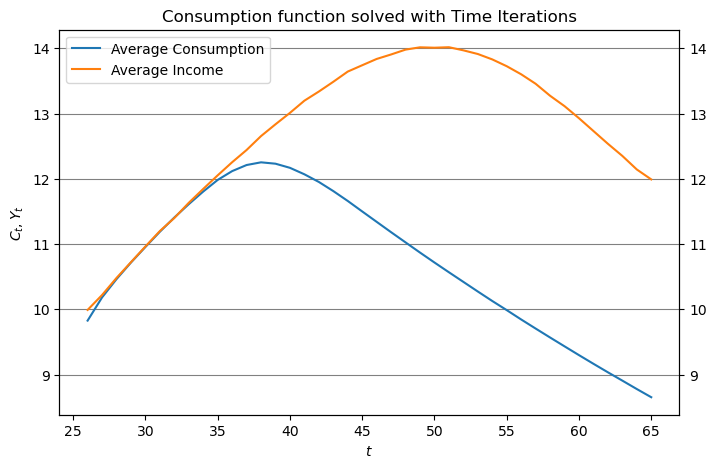

In [8]:
# Print consumption function
fig = pg.PlotFigure(figsize=(8,5),fontname='Arial')
x = range(par_init_sol.par.t0,par_init_sol.par.Tr+1)
fig.add_plot(x,sim.C_avg, label=f"Average Consumption", linestyle='-',axis='y1')
fig.add_plot(x,sim.Y_avg, label=f"Average Income", linestyle='-',axis='y1')
fig._set_scaling()
fig.set_ylabel(f"$C_t, Y_t$")
fig.set_xlabel(f"$t$")
fig.set_title(f'Consumption function solved with Time Iterations')
fig.add_gridlines(axis='y')
fig.add_legend()
fig.show()

# Estimation based on random data

### Data generation

In [9]:
# Setup params
par_dgp = model.gp_model().par
par_dgp.beta = 0.95
par_dgp.rho = 0.45
sol_dgp = egm.solver(par_dgp)
sol_dgp.solve(do_print=False)

dgp_par = [par_dgp.beta, par_dgp.rho]
# 
# sim_dgp = simulations.sim_setup(par_dgp)
# simulations.draw_random(par_dgp, sim_dgp)
# sim_dgp = simulations.simulate(sim_dgp, par_dgp, sol_dgp.sol)
sim_dgp = simulations.Simulator(par_dgp, sol_dgp.sol).sim

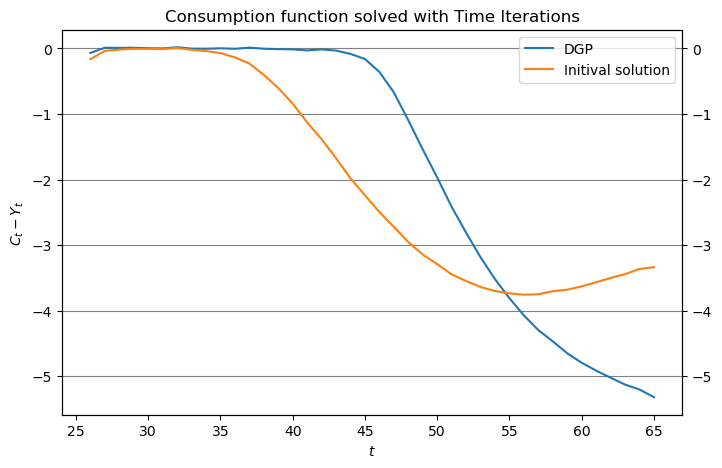

In [10]:
# Print consumption function
fig = pg.PlotFigure(figsize=(8,5),fontname='Arial')
x = range(par_init_sol.par.t0,par_init_sol.par.Tr+1)
y1 = sim_dgp.C_avg - sim_dgp.Y_avg
y2 = sim.C_avg - sim.Y_avg
fig.add_plot(x,y1, label=f"DGP", linestyle='-',axis='y1')
fig.add_plot(x,y2, label=f"Initival solution", linestyle='-',axis='y1')
fig._set_scaling()
fig.set_ylabel(f"$C_t - Y_t$")
fig.set_xlabel(f"$t$")
fig.set_title(f'Consumption function solved with Time Iterations')
fig.add_gridlines(axis='y')
fig.add_legend()
fig.show()

In [11]:
weight_mat_inv = np.eye(sim_dgp.C_avg.size)   # The identity matrix and I^-1=I
est = estimation.SMD(model=par_dgp,solver=egm.solver, simulator=simulations.Simulator, mom_data=sim_dgp.C_avg)

### grid search

In [12]:
est.beta_grid = np.arange(0.9,0.95,0.01)
est.rho_grid = np.arange(0.9,0.95,0.01)
est.estimate(theta0=[0.9,0.4],est_par=['beta','rho'],W=weight_mat_inv, grid=True)

### estimation

In [13]:
est.beta_grid = np.arange(0.9,0.95,0.01)
est.rho_grid = np.arange(0.9,0.95,0.01)
est.estimate(theta0=[0.9,0.4],est_par=['beta','rho'],W=weight_mat_inv, grid=False)

In [14]:
print(f'estimated values using grid method {est.est} and true parameters {dgp_par}')

estimated values using grid method [0.95000092 0.44997579] and true parameters [0.95, 0.45]


In [15]:
# Obtain the variance-covariance matrix
var_cov_matrix = est.estimate_variance_covariance_matrix(est.est, ['beta','rho'], W=weight_mat_inv)
print(var_cov_matrix)

[[ 1.61372834e+18 -4.66617513e+19]
 [-4.66617513e+19  1.34924757e+21]]


### plot the objective function for different values

In [16]:
# Sample data
x, y = np.meshgrid(np.arange(0.9,1,0.01), np.arange(0.9,1,0.01))
z = est.grid

# Create the surface plot
fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])

# Update layout
fig.update_layout(title='Objective function', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90),
                scene=dict(xaxis=dict(title='beta'),
                    yaxis=dict(title='rho')))

# Show the figure
fig.show()

# Estimation using data from BLS

In [17]:
cat = ['Under 25 years', '25-34 years', '35-44 years', '45-54 years', '55-64 years', '65 years and older']
data = [46359, 67883, 86049, 91074, 78079, 57818]
for i in range(6):
    print(f"{cat[i]}: {data[i]:,.1f}")


Under 25 years: 46,359.0
25-34 years: 67,883.0
35-44 years: 86,049.0
45-54 years: 91,074.0
55-64 years: 78,079.0
65 years and older: 57,818.0


In [18]:
# Setup
par_real = model.gp_model().par
# solve model
solObj = egm.solver(par_real)
solObj.solve()
sol_real = solObj.sol

real_par = [par_real.beta, par_real.rho]
# 
sim_real = simulations.Simulator(par_real, sol_real).sim

In [19]:
est.sim.C_avg
for i in range(0,len(est.sim.C_avg),10):
    print(f'{i+25}-{i+25+10}', est.sim.C_avg[i:i+10].mean())

25-35 11.04853877062116
35-45 13.02513670823114
45-55 11.781358527748585
55-65 8.025188248513619


In [20]:
real_data = np.array([67883, 86049, 91074, 78079])
real_data = np.log(real_data)
print(real_data)

[11.12554091 11.36267218 11.41942764 11.26547641]


In [21]:
weight_mat_inv = np.eye(real_data.size)   # The identity matrix and I^-1=I
est_real = estimation.SMD(model=par_real,solver=egm.solver, simulator=simulations.Simulator, mom_data=real_data)
est_real.age_groups = True

In [50]:
est_real.beta_grid = np.arange(0.85,0.95,0.01)
est_real.rho_grid = np.arange(0.0,0.2,0.01)
est_real.estimate(theta0=[0.9,0.4],est_par=['beta','rho'],W=weight_mat_inv,grid=True)

/Users/asbjornfyhn/Desktop/DP-life-cycle copy/utils.py:13: RuntimeWarning:

divide by zero encountered in scalar divide

/opt/anaconda3/envs/py39/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning:

invalid value encountered in divide

/opt/anaconda3/envs/py39/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning:

invalid value encountered in subtract



In [72]:
est_real.estimate(theta0=[0.9,0.4],est_par=['beta','rho'],bounds=[(0.6,1.05),(0.05,0.5)],W=weight_mat_inv,grid=False)

In [74]:
print(est_real.est_out.success)
print(f'estimated values {est_real.est} with objective function value {est_real.est_out.fun}')
#8.809801735250673 # first estimate
#8.809801787826778 # second estimate
#8.809801506099642 # third estimate

False
estimated values [0.90979024 0.06806095] with objective function value 8.809801506099642


In [52]:
if hasattr(est_real,'grid'):
  from plotly.subplots import make_subplots

  fig = make_subplots(
      rows=1, 
      cols=2,
      start_cell="top-left", 
      specs=[
          [{"type": "surface"}, {"type": "scattergl"}], 
      ]
  )
  fig.update_layout(paper_bgcolor="rgba(0,0,0,0)",plot_bgcolor="grey",font=dict(family="Arial",size=12,color="white"))
  # Sample data
  x, y = np.meshgrid(est_real.beta_grid, est_real.rho_grid)
  z = est_real.grid

  # Create the surface plot
  # fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])
  fig.add_trace(go.Surface(z=z, x=x, y=y, #coloraxis=dict(coloraxis=1),
                           ),row=1,col=1)

  # Update axes titles for the mesh plot
  fig.update_scenes(
      xaxis_title='Beta',
      yaxis_title='Rho',
      zaxis_title='Objective function',
      row=1, col=1
  )
  fig.update_scenes(aspectratio=dict(x=1, y=1, z=0.7),
                     row=1, col=1)

  fig.update_layout(title='Objective function', autosize=False,width=1000, height=500,margin=dict(l=65, r=50, b=65, t=90))
  # set the background color
  y = est_real.grid[np.where(est_real.beta_grid == est_real.est[0])[0],:][0]
  x = est_real.rho_grid

  # fig = go.Figure()
  fig.add_trace(go.Scatter(x=x, y=y, mode='lines', ),row=1,col=2)
  # Update axes titles for each subplot
  fig.update_xaxes(title_text=f'rho', row=1, col=2)
  fig.update_yaxes(title_text='Objective function', 
                   row=1, col=2)

  fig.show()
else:
  print('No grid found')

# Extension
Imagine two types of households with different timepreference, $\beta$

#### Type I

In [ ]:
# Setup params
par_type1 = model.gp_model().par
par_type1.beta = 0.99
sol_type1 = egm.solver(par_type1)
sol_type1.solve()
sol_type1 = sol_type1.sol

type1_par = [par_type1.beta, par_type1.rho]
# 
sim_type1 = simulations.Simulator(par_type1, sol_type1).sim

#### Type II

In [ ]:
# Setup params
par_type2 = model.gp_model().par
par_type2.beta = 0.90
sol_type2 = egm.solver(par_type2)
sol_type2.solve()
sol_type2 = sol_type2.sol

type2_par = [par_type2.beta, par_type2.rho]

sim_type2 = simulations.Simulator(par_type2, sol_type2).sim

#### Aggregate consumption
Denoting the share of type I households as $\lambda$, the aggregate consumption is given by:
$$
C^{agg}_t = \lambda C^I_t + (1-\lambda) C^{II}_t
$$

In [ ]:
lambda1 = 0.4
lambda2 = 1 - lambda1
agg_model = model.gp_model().par
agg_cons = lambda1*sim_type1.C_avg + lambda2 * sim_type2.C_avg

In [ ]:
# plot consumption
fig = pg.PlotFigure(figsize=(8,5),fontname='Arial')
x = range(par_init_sol.par.t0,par_init_sol.par.Tr+1)
fig.add_plot(x,agg_cons, label=f"Aggregate", linestyle='-',axis='y1')
fig.add_plot(x,sim_type1.C_avg, label=f"Type I", linestyle='-',axis='y1')
fig.add_plot(x,sim_type2.C_avg, label=f"Type II", linestyle='-',axis='y1')
fig.add_gridlines(axis='y')
fig.set_ylabel(f"$C_t$")
fig.set_xlabel(f"$t$")
fig.set_title(f'Consumption over life-cycle for different types')
fig.add_legend()
fig.show()


In [ ]:
weight_mat_inv = np.eye(agg_cons.shape[0])   # The identity matrix and I^-1=I
est_ext = estimation.SMD(model=agg_model,solver=egm.solver, simulator=simulations.Simulator, mom_data=agg_cons)

In [ ]:
est_ext.beta_grid = np.arange(0.9,0.99,0.01)
est_ext.rho_grid = np.arange(0.4,0.5,0.01)
est_ext.estimate(theta0=[0.9,0.4],est_par=['beta','rho'],W=weight_mat_inv, grid=True)

In [ ]:
# Sample data
x, y = np.meshgrid(np.arange(0.9,1,0.01), np.arange(0.9,1,0.01))
z = est_ext.grid

# Create the surface plot
fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])

# Update layout
fig.update_layout(title='Objective function', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90),
                scene=dict(xaxis=dict(title='beta'),
                    yaxis=dict(title='rho')))

# Show the figure
fig.show()
print(f'estimated values using grid method {est_ext.est} ')

In [ ]:
est_ext.estimate(theta0=[0.97,0.4],est_par=['beta','rho'],W=weight_mat_inv, grid=False)

In [ ]:
if est_ext.est_out.success:
    print(f'estimated values using scipy optimizer {est_ext.est}')
else:
    print(f'optimization failed')